<a href="https://colab.research.google.com/github/TinasheMafumbate/CNN/blob/master/tb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from tensorflow.keras.preprocessing import image
%matplotlib inline

from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Dense,GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D , Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import InceptionV3,InceptionResNetV2
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from glob import glob
from tqdm import tqdm

import os


In [ ]:
tf.random.set_seed(42) 


In [ ]:
working_dir = "/content/drive/My Drive/tb_images"
count=0
for folder in (os.listdir(working_dir)):
  count+=1
  print("{}. {}".format(count,folder))
 

1. test
2. train
3. Test.csv
4. Train.csv
5. SampleSubmission.csv


## Image Preprocessing and data augmentation

In [ ]:
train_csv = pd.read_csv('/content/drive/My Drive/tb_images/Train.csv',dtype=str)    # reading the csv file
train_csv.head()  

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [ ]:
def append_ext(fn):
    return fn+".png"

train_csv["ID"]=train_csv["ID"].apply(append_ext)

In [ ]:
train_csv.head() 

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO.png,1
1,train/GVVXXDOZ.png,GVVXXDOZ.png,0
2,train/PMRSQLXN.png,PMRSQLXN.png,0
3,train/JXISWDUU.png,JXISWDUU.png,1
4,train/JVWMAACC.png,JVWMAACC.png,1


In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=15,
        validation_split=0.2,
        fill_mode="nearest")

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train_csv,
directory="/content/drive/My Drive/tb_images/train",
x_col="ID",
y_col="LABEL",
subset="training",
batch_size=30,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(299,299))

Found 575 validated image filenames belonging to 2 classes.


In [ ]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory="/content/drive/My Drive/tb_images/train",
    x_col="ID",
    y_col="LABEL",
    batch_size=30,
    subset='validation',
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(299,299)
    )

Found 143 validated image filenames belonging to 2 classes.


In [ ]:
# Using tf.keras.utils.Sequence to view the shape of the training and validation images
print("Training set ", train_generator.__getitem__(0)[0].shape)
print("Validation set ", validation_generator.__getitem__(0)[0].shape)
print(train_generator.class_indices)
print(validation_generator.class_indices)

Training set  (30, 299, 299, 3)
Validation set  (30, 299, 299, 3)
{'0': 0, '1': 1}
{'0': 0, '1': 1}


## Implementation of Transfer learning model

In [ ]:
# A function that will be called for plotting the graphs of accuracy and loss values

def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

In [ ]:
filepath="inception_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)



In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', 
                          include_top=False,
                          input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 8, 8, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1, activation='softmax'))

In [ ]:
# add a global spatial maximum pooling layer
# x = base_model.output
# x = GlobalMaxPooling2D()(x)
# x = Dense(64, activation='tanh')(x)
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# for layer in model.layers:
#     layer.trainable = True
#     if isinstance(layer, tf.keras.layers.BatchNormalization): 

#       # we do exponential smoothing of batch norm
#       # parameters to faster adjust to our new dataset
#       layer.momentum = 0.9
    
# # fix deep layers (fine-tuning only last 50)
# for layer in model.layers[:-50]:
#     # fix all but batch norm layers, because we need to update moving averages for a new dataset!
#     if not isinstance(layer, tf.keras.layers.BatchNormalization):
#         layer.trainable = False


In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy ,
              #optimizer=tf.keras.optimizers.RMSprop(lr=0.01, decay=1e-6),   
             # optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              optimizer=tf.keras.optimizers.Nadam(lr=0.001, decay=1e-6),  
              metrics=['accuracy'])

# fitting the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples// 30,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples//30,
    epochs = 50,
    callbacks=[es_callback,lr_reduce,checkpoint]
    )



Epoch 1/50
17/19 [=========================>....] - ETA: 6s - loss: 7.6403 - accuracy: 0.4990 

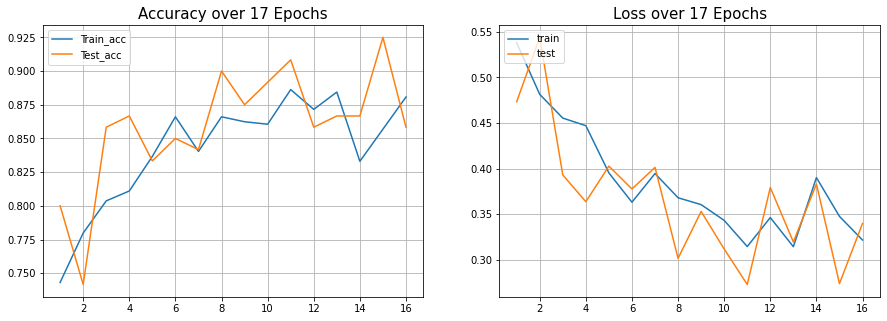

In [ ]:
plot_acc_loss(history, len(history.epoch))

## Evaluating the model

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator,  verbose=1)
print('\nTest accuracy:', test_acc)

5/5 [==============================] - 15s 3s/step - loss: 0.3464 - accuracy: 0.8881

Test accuracy: 0.8881118893623352


## Performance Metrics and Classification report

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.models import load_model

In [ ]:
validation_generator.__getitem__(4)[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0.], dtype=float32)

In [ ]:
classes_b1=validation_generator.__getitem__(0)[1] 
classes_b2=validation_generator.__getitem__(1)[1] 
classes_b3=validation_generator.__getitem__(2)[1] 
classes_b4=validation_generator.__getitem__(3)[1] 
classes_b5=validation_generator.__getitem__(4)[1] 
 

classes_arr=np.concatenate((classes_b1, classes_b2,classes_b3,classes_b4,classes_b5))
classes_arr

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 0., 0.], dtype=float32)

In [ ]:
# classes_val = np.argmax(classes_arr, axis=1)
# classes_val

In [ ]:
#Confusion Matrix and Classification Report
model=load_model('inception_weights.hdf5')
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(classes_arr, y_pred))
print('Classification Report')
classes = ['0', '1']

print(classification_report(classes_arr, y_pred, target_names=classes))

AttributeError: ignored

In [ ]:
Y_pred

array([[0.16441002],
       [0.9548894 ],
       [0.9548894 ],
       [0.12390025],
       [0.14260943],
       [0.9548349 ],
       [0.8674972 ],
       [0.12403174],
       [0.87759936],
       [0.74170965],
       [0.14262478],
       [0.9548881 ],
       [0.12351491],
       [0.24631768],
       [0.68669426],
       [0.67297935],
       [0.5911132 ],
       [0.12403931],
       [0.30347094],
       [0.5841551 ],
       [0.9548484 ],
       [0.1234603 ],
       [0.9197432 ],
       [0.938251  ],
       [0.3216165 ],
       [0.12346929],
       [0.62906   ],
       [0.14032684],
       [0.14166215],
       [0.14646196],
       [0.14247242],
       [0.14545275],
       [0.1340501 ],
       [0.95488983],
       [0.9548894 ],
       [0.39243415],
       [0.12402869],
       [0.17196395],
       [0.13725246],
       [0.8808397 ],
       [0.9001431 ],
       [0.35410848],
       [0.8059132 ],
       [0.38874206],
       [0.9548894 ],
       [0.16238731],
       [0.14252062],
       [0.848

In [ ]:
from tensorflow.keras.preprocessing import image

classes = ['Covid-19', 'No_Covid-19', 'Pneumonia']

testimg=image.load_img("/content/drive/My Drive/Colab Notebooks/X-Ray Image dataset/Covid-19/1-s2.0-S0929664620300449-gr2_lrg-b.jpg",target_size=(299, 299))
testimg=image.img_to_array(testimg)
testimg=np.expand_dims(testimg,axis=0)
testimg= testimg/255.0
result1=model.predict(testimg)
print(result1)
print(train_generator.class_indices)
print("The image is predicted as class {}: {}".format(np.argmax(result1[0]),classes[np.argmax(result1[0])]))

[[0.6574892  0.02322978 0.31928104]]
{'Covid-19': 0, 'No_Covid-19': 1, 'Pneumonia': 2}
The image is predicted as class 0: Covid-19


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.3.0


## Deployment

Deployment was made with Tensoflow Serving platform , with the following steps and can be obtained on the following link http://localhost:8501/v1/models/covid_model:predict , which is accessible after running on local host.

In [ ]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0


Installing dependencies for Colab environment
     |████████████████████████████████| 2.4MB 115kB/s 


In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
    
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 5992
drwxr-xr-x 2 root root    4096 Aug 23 14:31 assets
-rw-r--r-- 1 root root 6124988 Aug 23 14:31 saved_model.pb
drwxr-xr-x 2 root root    4096 Aug 23 14:31 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 299, 299, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_6'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  14426      0 --:--:-- --:--:-- --:--:-- 14497
OK
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:8 http://storage.googleapis.com/tensorflow-ser

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 60 not upgraded.
Need to get 210 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.3.0 [210 MB]
Fetched 210 MB in 3s (75.9 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.3.0_all.deb ...
Unpacking tensorflow-model-server (2.3.0) ...
Setting up tensorflow-model-server (2.3.0) ...


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=covid_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-08-22 11:18:07.469925: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:199] Restoring SavedModel bundle.
2020-08-22 11:18:08.224331: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /tmp/1
2020-08-22 11:18:08.480850: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 1237776 microseconds.
2020-08-22 11:18:08.512684: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-08-22 11:18:08.512818: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: covid_model version: 1}
2020-08-22 11:18:08.515015: I tensorflow_serving/model_servers/server.cc:367] Running gRPC ModelServer at 0.0.0.0:8500 ...
[wa

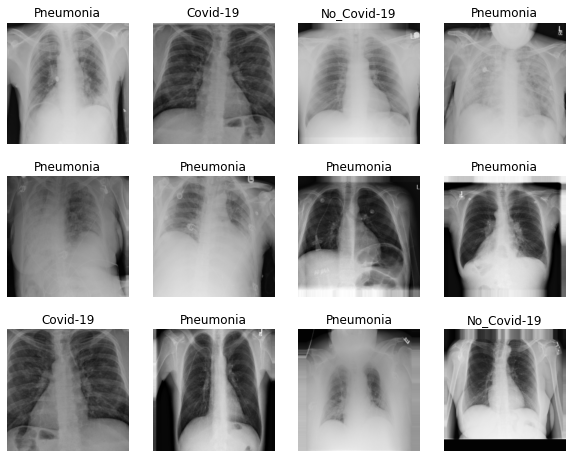

In [ ]:
data = train_generator.__getitem__(1)[0] 
label = train_generator.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(data[i])
    plt.title(classes[np.argmax(label[i])])

In [ ]:
classes = ['Covid-19', 'No_Covid-19', 'Pneumonia']

data1 = validation_generator.__getitem__(1)[0] 
label = train_generator.__getitem__(1)[1] 

import json
data = json.dumps({"signature_name": "serving_default", "instances": data1[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]]]}


In [ ]:
!pip install -q requests

In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/covid_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

print(0, 'The model predicts that the image is in class {} (class {}), and it was actually a {} (class {})'.format(
  validation_generator.classes[np.argmax(predictions[0])], np.argmax(predictions[0]), validation_generator.classes, validation_generator.classes))

0 The model predicts that the image is in class 0 (class 1), and it was actually a [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2] (class [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2

1. Lai, Z., & Deng, H. (2018). Medical image classification based on deep features extracted by deep model and statistic feature fusion with multilayer perceptron. Computational Intelligence and Neuroscience, 2018. https://doi.org/10.1155/2018/2061516

2. Pelt, D. M., & Sethian, J. A. (2017). A mixed-scale dense convolutional neural network for image analysis. Proceedings of the National Academy of Sciences of the United States of America, 115(2), 254–259. https://doi.org/10.1073/pnas.1715832114